In [99]:
import numpy as np
import pandas as pd
import sys
from sklearn import preprocessing
from sklearn.pipeline import FeatureUnion, Pipeline, make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn import tree
import sklearn.model_selection as model_selection
import joblib

In [100]:
csvPath = "D:\\ARTIFICIAL INTELLIGENCE\\2020\\KLASIFIKASI\\Bantul_edited.csv"

data = pd.read_csv(csvPath, encoding= 'unicode_escape')

data['Class'] = data['Class'].fillna(value=0.0)
data.shape

# drop nulls
data = data.dropna(axis=0, subset=['namaoutput', 'namaprogram', 'namaoutcome', 'namakegiatan', 'satuanoutput', 'satuanoutcome'])

data.shape

(1336, 33)

In [101]:
import re

# drop digit in sentences
data['clean_namaoutcome'] = data['namaoutcome'].str.lower().apply(lambda input_term : re.sub('[0-9]+', '', input_term))
data['clean_namaoutput'] = data['namaoutput'].str.lower().apply(lambda input_term : re.sub('[0-9]+', '', input_term))
data['clean_namaprogram'] = data['namaprogram'].str.lower().apply(lambda input_term : re.sub('[0-9]+', '', input_term))
data['clean_namakegiatan'] = data['namakegiatan'].str.lower().apply(lambda input_term : re.sub('[0-9]+', '', input_term))


In [102]:
vector_file = "D:\\ARTIFICIAL INTELLIGENCE\\2020\\Word2Vec\\CBOW\\TXT\\corpus-plus-simral-40-1-vector.txt"
vocab_file = "D:\\ARTIFICIAL INTELLIGENCE\\2020\\Word2Vec\\CBOW\\TXT\\corpus-plus-simral-40-1-vocab.txt"

with open(vocab_file, 'r', encoding='utf-8') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
    
with open(vector_file, 'r', encoding='utf-8') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]

vocab_size = len(words)
vocab = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}

vector_dim = len(vectors[ivocab[0]])
W = np.zeros((vocab_size, vector_dim))
for word, v in vectors.items():
    if word == '<unk>':
        continue
    W[vocab[word], :] = v
    
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))

W_norm = (W.T / d).T

lst_keys = [y for y in vocab.keys()]

In [103]:
def calculate_vocab_in_list(input_term):
    count_words = 0
    for idx, term in enumerate(input_term.split(' ')):
        if term in vocab:
            count_words = count_words + 1
    
    return count_words

In [104]:
# calculate words that is not OOV in each sentences
# we should remove the sentences which all of words in it is/are OOV
data['count_vocab_namaoutput'] = data['clean_namaoutput'].str.lower().apply(lambda input_term : calculate_vocab_in_list(input_term))
data['count_vocab_namaoutcome'] = data['clean_namaoutcome'].str.lower().apply(lambda input_term : calculate_vocab_in_list(input_term))
data['count_vocab_namakegiatan'] = data['clean_namakegiatan'].str.lower().apply(lambda input_term : calculate_vocab_in_list(input_term))
data['count_vocab_namaprogram'] = data['clean_namaprogram'].str.lower().apply(lambda input_term : calculate_vocab_in_list(input_term))

In [105]:
data[['count_vocab_namaoutput', 'count_vocab_namaoutcome', 'count_vocab_namakegiatan', 'count_vocab_namaprogram']]

,count_vocab_namaoutput,count_vocab_namaoutcome,count_vocab_namakegiatan,count_vocab_namaprogram
0,2,4,9,9
1,6,7,5,7
2,2,5,7,7
3,7,4,5,9
4,4,7,6,9
...,...,...,...,...
1365,4,3,3,5
1366,3,3,4,5
1367,5,4,3,5
1368,3,3,2,5


In [106]:
# Check which instance has full OOV in either namaoutcome, namaoutput, namaprogram, or namakegiatan
data[(data['count_vocab_namaoutcome']==0) | (data['count_vocab_namaoutput']==0) | (data['count_vocab_namaprogram']==0) | (data['count_vocab_namakegiatan']==0)]

,Class,tahunanggaran,kodefungsi,namafungsi,kodeurusanprogram,namaurusanprogram,kodeurusanpelaksana,namaurusanpelaksana,kodeskpd,namaskpd,...,namasumberdana,nilaianggaran,clean_namaoutcome,clean_namaoutput,clean_namaprogram,clean_namakegiatan,count_vocab_namaoutput,count_vocab_namaoutcome,count_vocab_namakegiatan,count_vocab_namaprogram
385,0,2019,7,Kesehatan,102,Kesehatan,102,Kesehatan,102,RSUD Panembahan Senopati,...,APBD Kabupaten/Kota,1.411981e+09,"bor,bto",terlaksananya kegiatan publikasi dan promosi d...,"program pengadaan, peningkatan sarana dan pras...",pengadaan sarana dan prasarana rumah sakit lai...,19,0,7,13
453,0,2019,3,Ketertiban dan ketentraman,105,"Ketentraman, Ketertiban Umum dan Perlindungan ...",105,"Ketentraman, Ketertiban Umum dan Perlindungan ...",105,Kantor Kesatuan Bangsa dan Politik,...,APBD Kabupaten/Kota,8.280000e+07,meningkatnya pemahaman tentang bahaya narkoba,"raker,sosialisasi",program peningkatan pemberantasan penyakit mas...,pencegahan penyalahgunaan narkoba,0,5,3,5
551,0,2019,1,Pelayanan Umum,204,Pertanahan,204,Pertanahan,204,Dinas Pertanahan dan Tata Ruang,...,"APBD Kabupaten/Kota,Dana Alokasi Umum",1.101788e+09,kelancaran tugas kantor,"drone,server",program peningkatan sarana dan prasarana aparatur,pengadaan peralatan dan perlengkapan,0,3,4,6
964,0,2019,1,Pelayanan Umum,407,Fungsi Lainnya,407,Fungsi Lainnya,401,Kecamatan Bambanglipuro,...,APBD Kabupaten/Kota,9.000000e+06,tertib pengunjung,"paten,iumk",program peningkatan pelayanan masyarakat,peningkatan pelayanan masyarakat,0,2,3,4
1265,0,2019,1,Pelayanan Umum,407,Fungsi Lainnya,407,Fungsi Lainnya,401,Kecamatan Pundong,...,APBD Kabupaten/Kota,4.374400e+07,pelayanan masyarakat yang memuaskan,"paten,iumk",program peningkatan pelayanan masyarakat,peningkatan pelayanan masyarakat,0,4,3,4


In [108]:
data.drop(data[(data['count_vocab_namaoutcome']==0) | (data['count_vocab_namaoutput']==0) | (data['count_vocab_namaprogram']==0) | (data['count_vocab_namakegiatan']==0)].index, inplace = True)


In [109]:
class SentenceEmbeddingTransform():
    def __init__(self, wordList, vocab, W_norm):
        print()
        self.wordList = wordList
        self.W_norm = W_norm
        self.vocab = vocab
    
    def fit(self, X, y = None):
        return self
    
    def mean_of_word_embedding(self, input_term):
        words_inDict = np.empty([0])
        
        for idx, term in enumerate(input_term.split(' ')):
            if term in self.vocab:
                words_inDict = np.append(words_inDict, term)
                
        vec_sentence_embed = [self.W_norm[self.vocab[y], :] for y in words_inDict]
        if (len(vec_sentence_embed) == 0):
            print (input_term)
        vec_sentence_embed_stack = np.vstack(vec_sentence_embed)
        vec_sentence_embed_stack_mean = np.mean(vec_sentence_embed_stack, axis=0)
        
        return vec_sentence_embed_stack_mean
    
    def transform(self, X, y = None):
        X_ = X.copy()
        
        ret_array = []
        
        for sentence in X_:
            arr_result = self.mean_of_word_embedding(sentence.lower())
            ret_array.append(arr_result)

        return np.array(ret_array)
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

In [110]:
class MyLabelEncoder():

    def transform(self, X, y=None, **fit_params):
        enc = preprocessing.LabelEncoder()
        encc = enc.fit(X)
        enc_data = enc.transform(X).reshape(-1, 1)

        return enc_data

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X).reshape(-1, 1)

    def fit(self, X, y=None, **fit_params):
        return self

In [111]:
def get_text_satuan_outcome(df):
    return df['satuanoutcome']

def get_text_satuan_output(df):
    return df['satuanoutput']

def get_text_nama_program(df):
    return df['namaprogram']

def get_text_nama_kegiatan(df):
    return df['namakegiatan']

def get_text_nama_output(df):
    return df['namaoutput']

def get_text_nama_outcome(df):
    return df['namaoutcome']

In [135]:
joblib_model = joblib.load('mowe_pipeline_model.pkl')

In [136]:
data_column_used = data[['namaprogram', 'satuanoutcome', 'satuanoutput', 'namakegiatan', 'namaoutput', 'namaoutcome']]
data_target = data['Class'].astype(int)

In [137]:
data_column_used

,namaprogram,satuanoutcome,satuanoutput,namakegiatan,namaoutput,namaoutcome
0,Program peningkatan pengembangan sistem pelapo...,dokumen,dokumen,Penyusunan laporan capaian kinerja dan ikhtisa...,Jumlah Dokumen,Terlapornya Capaian Kinerja SKPD
1,Program Wajib Belajar Pendidikan Dasar Sembila...,surat izin,surat izin,Perijinan SD dan SMP Baru,jumlah terbitnya surat izin/ rekomendasi sekol...,terselenggaranya program perijinan SD dan SMP ...
2,Program Peningkatan Mutu Pendidik dan Tenaga K...,dokumen,dokumen,Pendataan dan pemetaan pendidik dan tenaga kep...,Jumlah dokumen,Terlaksananya Kegiatan Pendataan di Dikpora
3,Program peningkatan pengembangan sistem pelapo...,%,"dokumen,orang",Perencanaan dan Koordinasi Program Kegiatan,Jumlah dokumen perencanaan program dan anggara...,Meningkatnya koordinasi perencanaan program
4,Program peningkatan pengembangan sistem pelapo...,%,"dokumen,orang","Penyusunan laporan capaian kinerja, keuangan, ...","Jumlah dokumen laporan,Jumlah makan/minum rapat","Kelancaran penyusunan laporan capaian kinerja,..."
...,...,...,...,...,...,...
1365,Program pembinaan sosial kemasyarakatan kecamatan,persen,kali,Penyelenggaraan lomba desa,jumlah monitoring lomba desa,Terlaksananya lomba desa
1366,Program Pemberdayaan Masyarakat Tingkat Kecamatan,persen,kali,Pengembangan Produk Unggulan Kecamatan,Keikutsertaan Bantul Ekspo,Pameran produk unggulan
1367,Program Pemberdayaan Masyarakat Tingkat Kecamatan,persen,kali,Pembinaan Organisasi Perempuan,jumlah rakor Tim Penggerak PKK,Terselenggarannya kegiatan organisasi perempuan
1368,Program Pemberdayaan Masyarakat Tingkat Kecamatan,persen,kali,Pemberdayaan Petani,jumlah pembinaan petani,Meningkatnya produktifitas petani


In [138]:
labels_pred = joblib_model.predict(data_column_used)

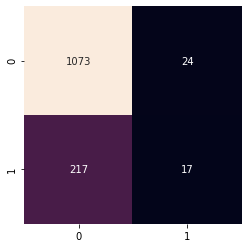

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as plt
mat = confusion_matrix(labels_pred, data_target)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])

In [140]:
from sklearn.metrics import accuracy_score

accuracy_score(labels_pred, data_target)

0.8189331329827197

In [141]:
from sklearn.metrics import classification_report

print (classification_report(labels_pred, data_target, target_names=['non-doc', 'doc']))

              precision    recall  f1-score   support

     non-doc       0.98      0.83      0.90      1290
         doc       0.07      0.41      0.12        41

    accuracy                           0.82      1331
   macro avg       0.53      0.62      0.51      1331
weighted avg       0.95      0.82      0.88      1331

